In [1]:
import importlib
import dbops
import utils
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import glob

In [2]:
importlib.reload(dbops)  # Reload the module from source

<module 'dbops' from '/scratch/u1319464/Data-Mining-Spring-2025-Project/dbops.py'>

In [3]:
movie_ref = dbops.Movie.iterate_all_movies()[10]
str(movie_ref)

'The Matrix'

In [4]:
[ i.get_title() for i in dbops.Movie.iterate_all_movies() ][:6]

['Earth vs. the Flying Saucers',
 'The Wolf Man',
 'Dracula',
 'Taxi Driver',
 'Natural Born Killers',
 "The Bishop's Wife"]

In [5]:
[ i.get_title() for i in dbops.Movie.iterate_all_movies() ][6:12]

['Kronos',
 'Sahara',
 'It Came from Outer Space',
 'Tarantula',
 'The Matrix',
 'Frankenstein']

In [6]:
[ i.get_title() for i in dbops.Movie.iterate_all_movies() ][12:]

['Hellhole',
 'Fight Club',
 'The Day the Earth Stood Still',
 'Taxi Driver: A XXX Parody',
 'Invasion of the Body Snatchers',
 'The Invisible Man (1933)']

In [24]:
imdb_id = movie_ref.get_imdb_id()
title = movie_ref.get_title()
frame_idx_timeline = []
# num_faces_timeline = []
color_timeline = []
emotion_embedding_timeline = []
emotion_timeline = []
for frame_ref in tqdm(movie_ref.iterate_frames()):
    # if not frame_ref.is_fully_cached():
    #     print(f'Uncached frame found: {frame_ref.frame_index}')
    
    # try:
    #     num_faces_timeline.append(frame_ref.get_num_faces())
    # except:
    #     num_faces_timeline.append(0)
    
    c = frame_ref.get_average_color()
    color_timeline.append(c)

    frame_emotion_embeddings = []
    frame_emotions = []
    for face_ref in frame_ref.iterate_faces():
        frame_emotion_embeddings.append(face_ref.get_emotion_embeddings()[0].get_embedding())
        frame_emotions.append(face_ref.get_emotion_embeddings()[0].get_classification_confidence())
        frame_idx_timeline.append(frame_ref.frame_index)

    
    emotion_timeline.append(frame_emotions)
    emotion_embedding_timeline.append(frame_emotion_embeddings)


color_timeline = np.array(color_timeline)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4753/4753 [00:01<00:00, 3458.63it/s]


Text(0.5, 1.0, 'Overall Processing Progress of "The Matrix"')

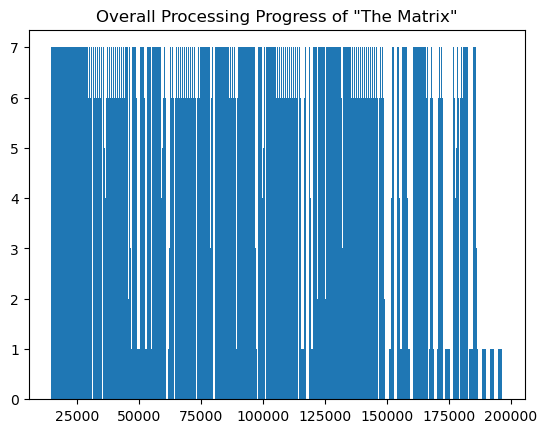

In [8]:
plt.hist(
    frame_idx_timeline,
    bins=15*60 # for every interval of ~15 seconds
)
plt.title(f'Overall Processing Progress of "{title}"')

In [9]:
[len(x) for x in [frame_idx_timeline, color_timeline, emotion_timeline]]

[4753, 4753, 4753, 4753]

In [10]:
draw_order = np.argsort(np.linalg.norm(color_timeline, axis=1))


x


4753it [00:00, 907686.88it/s]


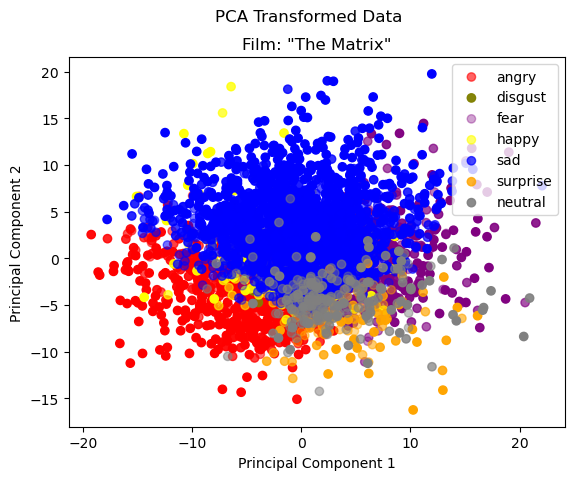

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Sample data
X = np.concatenate([ np.stack(j) for j in emotion_embedding_timeline if not len(j)==0 ])
y = np.concatenate([ np.stack(j)[:,0] for j in emotion_timeline if not len(j)==0 ])
y_p = np.concatenate([ np.stack(j)[:,1] for j in emotion_timeline if not len(j)==0 ]).astype(np.float32)

# Initialize PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print('x')

colors = []
for color_timeline_i, emotion_timeline_i in tqdm(zip(color_timeline, emotion_embedding_timeline)):
    for _ in range(len(emotion_timeline_i)):
        colors.append(color_timeline_i)

colors = np.array(colors)
# utils.fudge_luminance(colors/255, 1.5, 0.2)
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, label='PCA Transformed Data')
for emotion_label in utils.emotion_labels:

    X_pca_i = X_pca[y==emotion_label]
    y_p_i = y_p[y==emotion_label]
    if len(X_pca_i)>0:
        plt.scatter(
            X_pca_i[:,0],
            X_pca_i[:,1],
            c=utils.emotion_label_colors[emotion_label],
            label=emotion_label,
            alpha=y_p_i
        )

plt.suptitle('PCA Transformed Data')
plt.title(f'Film: "{movie_ref.get_title()}"')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

plt.show()

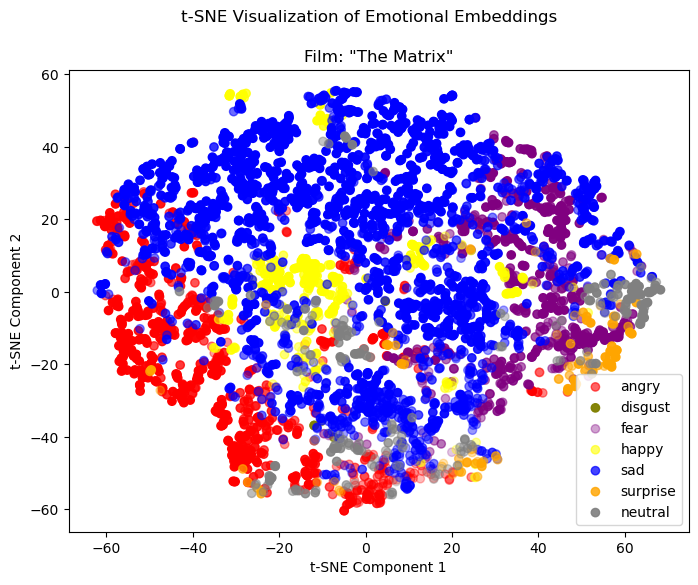

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Step 2: Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Step 3: Plot the results
plt.figure(figsize=(8, 6))
# scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y/7)

for emotion_label in utils.emotion_labels:

    X_tsne_i = X_tsne[y==emotion_label]
    y_p_i = y_p[y==emotion_label]
    if len(X_tsne_i)>0:
        plt.scatter(
            X_tsne_i[:,0],
            X_tsne_i[:,1],
            c=utils.emotion_label_colors[emotion_label],
            label=emotion_label,
            alpha=y_p_i
        )

# plt.colorbar(scatter, ticks=range(len(), label='Species')
plt.suptitle('t-SNE Visualization of Emotional Embeddings')
plt.title(f'Film: "{movie_ref.get_title()}"')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

Explained variance ratio: [0.3972372  0.27541453]
Means of classes: [[ 4.5667477  -4.125675   -4.885513   -3.0409977   0.6951005  -3.946984
  -3.8225484 ]
 [-1.3999151   2.0325263  -1.6358248  -3.5425317   0.09961081 -5.1633835
  -2.6106284 ]
 [-3.4034264  -7.707159    3.995021   -3.9163392   0.81874603 -2.6639802
  -3.5665143 ]
 [-2.072514   -7.4894285  -3.9559164   4.613861    0.37918755 -5.805304
  -3.0197723 ]
 [-2.300124   -7.3822064  -2.6924248  -3.9052432  -0.500248   -2.8126473
   2.9649994 ]
 [-1.6082326  -6.289475   -1.9148096  -2.7421954   5.1937118  -5.639444
  -3.3387835 ]
 [-2.0015109  -8.054463   -1.6857294  -4.3604527  -1.8496132   2.870388
  -1.8453826 ]]
Scalings (eigenvectors): [[ 0.07198291 -0.24449791 -0.10262772  0.17143342 -0.16434377  0.33541438]
 [-0.10224318 -0.06016657 -0.02431165 -0.004711   -0.02117807 -0.31183383]
 [-0.06759053  0.091805   -0.13397062  0.18873702 -0.20325443  0.16626525]
 [-0.04526263  0.00091232  0.20620164  0.16242163 -0.02429878  0.1512

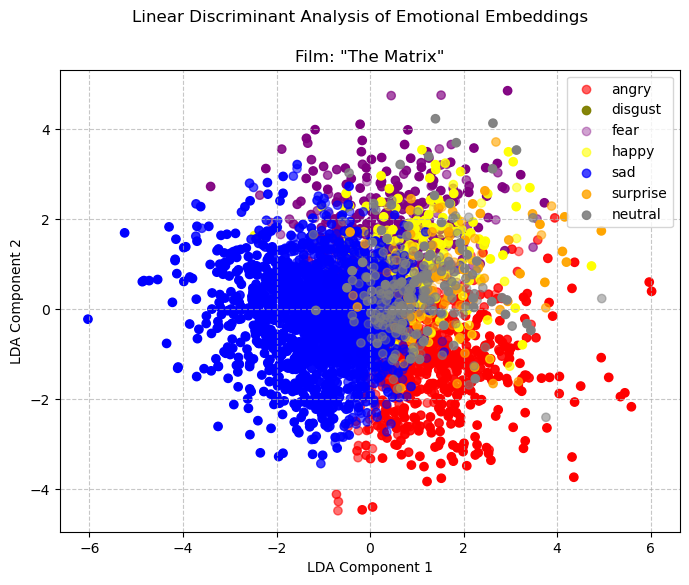

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Step 2: Apply Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(n_components=2)  # Reduce to 2 dimensions
X_lda = lda.fit_transform(X, y)

# Step 3: Plot the results
plt.figure(figsize=(8, 6))
# color=utils.fudge_luminance(colors/255, 1.5, 0.2)
# scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y/7)
for emotion_label in utils.emotion_labels:

    X_lda_i = X_lda[y==emotion_label]
    y_p_i = y_p[y==emotion_label]
    
    if len(X_lda_i)>0:
        plt.scatter(
            X_lda_i[:,0],
            X_lda_i[:,1],
            c=utils.emotion_label_colors[emotion_label],
            label=emotion_label,
            alpha=y_p_i
        )
plt.suptitle('Linear Discriminant Analysis of Emotional Embeddings')
plt.title(f'Film: "{movie_ref.get_title()}"')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
# Step 4: Optional - Analysis of components
print("Explained variance ratio:", lda.explained_variance_ratio_)
print("Means of classes:", lda.means_)
print("Scalings (eigenvectors):", lda.scalings_)

plt.show()

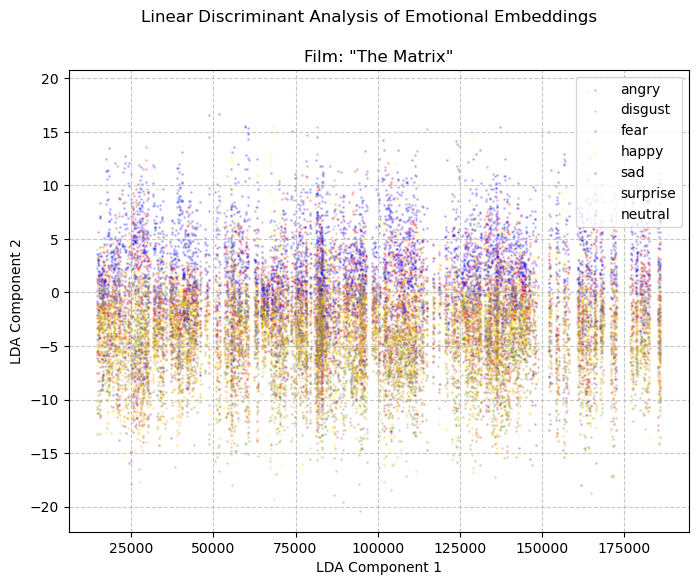

In [50]:
# measure of emotinoal complexity of each face in a frame:
# diversity of the emotion embedding for each face
# length of the emotional embedding

# plt.scatter(frame_idx_timeline, np.linalg.norm(X, axis=1))
# plt.scatter(frame_idx_timeline, np.sum(np.abs(X), axis=1), s=1)

plt.figure(figsize=(8, 6))


for i, emotion_label in enumerate(utils.emotion_labels):
    plt.scatter(
        frame_idx_timeline,
        X[:,i],
        s=1,
        label=emotion_label,
        alpha=0.2,
        c=utils.emotion_label_colors[emotion_label]
    )

plt.suptitle('Linear Discriminant Analysis of Emotional Embeddings')
plt.title(f'Film: "{movie_ref.get_title()}"')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
None

In [34]:
X.max(axis=0)

array([15.414027 ,  6.6170874, 16.568855 , 15.422729 , 18.83167  ,
        9.67892  , 10.914916 ], dtype=float32)

In [23]:
np.linalg.norm(X, axis=1).shape

(3779,)

In [31]:
X

array([[ -5.570503  , -11.27627   ,  -4.3723254 , ...,   1.2151374 ,
         -1.0348184 ,  -0.2614648 ],
       [ -4.2541428 ,  -8.274871  ,   0.09918002, ...,   3.6702209 ,
         -7.4587436 ,  -5.6971292 ],
       [  0.52893597,  -4.946578  ,  -2.8568628 , ...,   1.623239  ,
         -3.3476467 ,   0.20783745],
       ...,
       [ -2.110176  , -10.987107  , -10.211446  , ...,   2.7442818 ,
         -8.204884  ,  -0.38496992],
       [ -6.285093  , -13.451464  ,   6.326181  , ...,   8.252706  ,
         -1.2300065 ,  -4.283472  ],
       [ -1.8331271 ,  -6.172401  ,  -0.6132548 , ...,   5.599495  ,
         -6.8807316 ,  -3.6451352 ]], dtype=float32)